In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import polars as pl # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import os
from pathlib import Path
import sys
import matplotlib as plt
from matplotlib import pyplot
import gc

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
base_path = Path("/kaggle/input/jane-street-real-time-market-data-forecasting/")
train_path = base_path / Path("train.parquet")
train_read_paths = [train_path / Path(f"partition_id={i}/part-0.parquet") for i in [0, 1, 2, 3, 4, 5, 6, 7]]
df = pl.concat([pl.read_parquet(path) for path in train_read_paths])

In [3]:
df.shape

(34712738, 92)

In [4]:
df.estimated_size()

12374113098

## Weights

In [5]:
df['weight'].describe()

statistic,value
str,f64
"""count""",3.4712738e7
"""null_count""",0.0
"""mean""",1.829044
"""std""",1.034102
"""min""",0.149967
"""25%""",1.113869
"""50%""",1.599985
"""75%""",2.262497
"""max""",10.240419


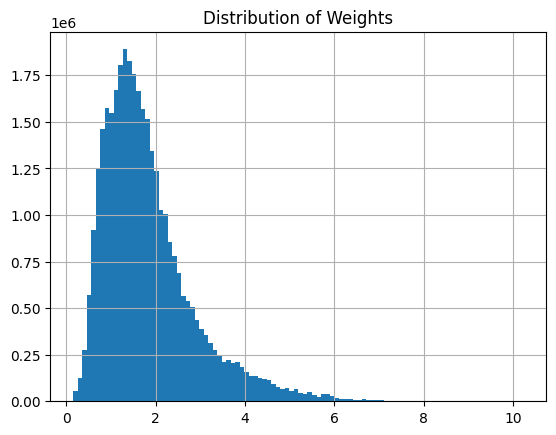

In [6]:
fig, axis = pyplot.subplots(1, 1)
axis.hist(df['weight'], bins=100)
axis.set_title("Distribution of Weights")
axis.grid()
fig.show()

## Features

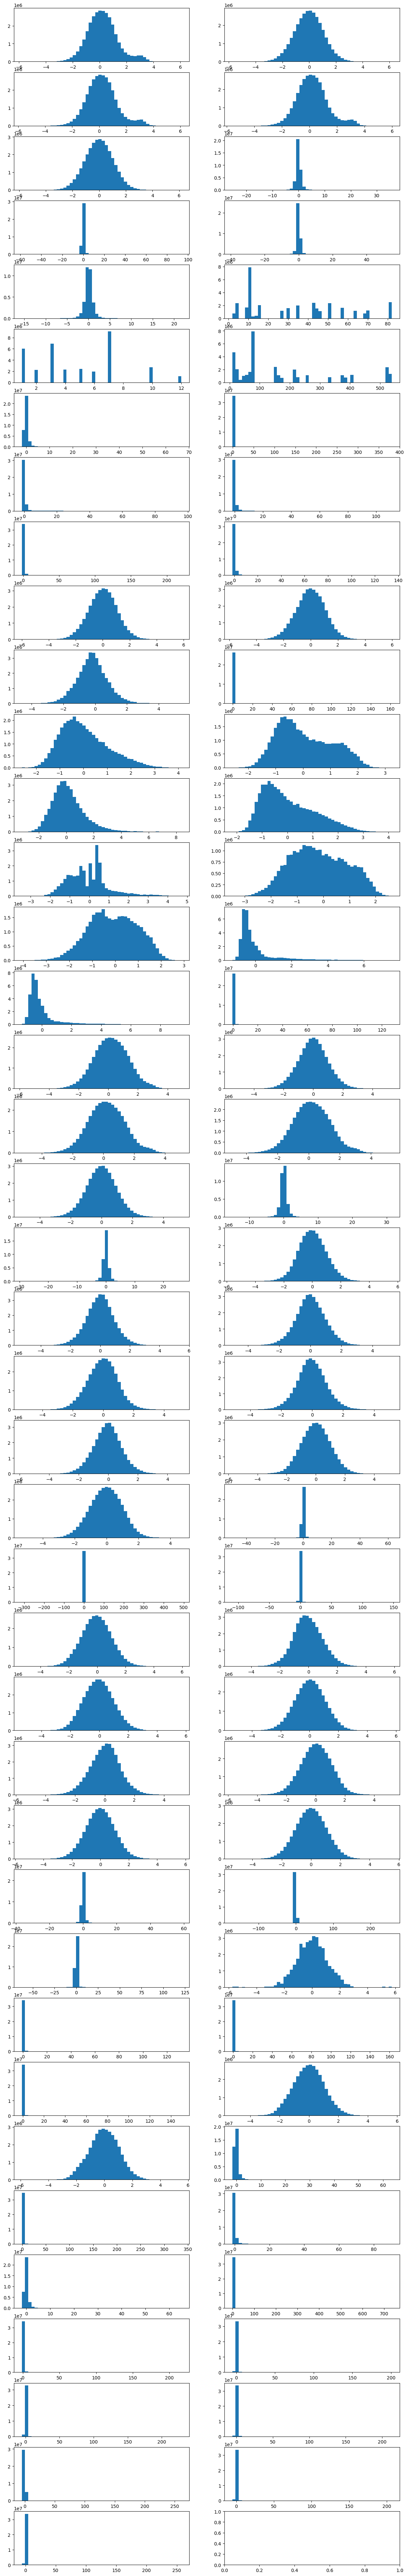

In [7]:
features = [i for i in df.columns if i.startswith('feature_')]

fig, axis = pyplot.subplots(40, 2, figsize=(15, 100))
for i, name in enumerate(features):
    axis[i // 2][i % 2].hist(df[name], bins=50)
fig.show()

In [8]:
median_before = [df[i].quantile(0.5) for i in features]
stds_before = [df[i].std() for i in features]

outlier_low = [median - 3 * std for median, std in zip(median_before, stds_before)]
outlier_high = [median + 3 * std for median, std in zip(median_before, stds_before)]

In [9]:
for name, lo, hi in zip(features, outlier_low, outlier_high):
    if df.schema[name] == pl.Int8:
        lo = max(lo, -127)
        hi = min(hi, 127)
    df = df.with_columns(df[name].clip(lo, hi))

In [10]:
means = [df[i].mean() for i in features]
stds = [df[i].std() for i in features]

In [11]:
pl.DataFrame({
    'name': features,
    'mean': means,
    'std': stds,
    'lo': outlier_low,
    'hi': outlier_high
}).write_csv('feature_data.csv')

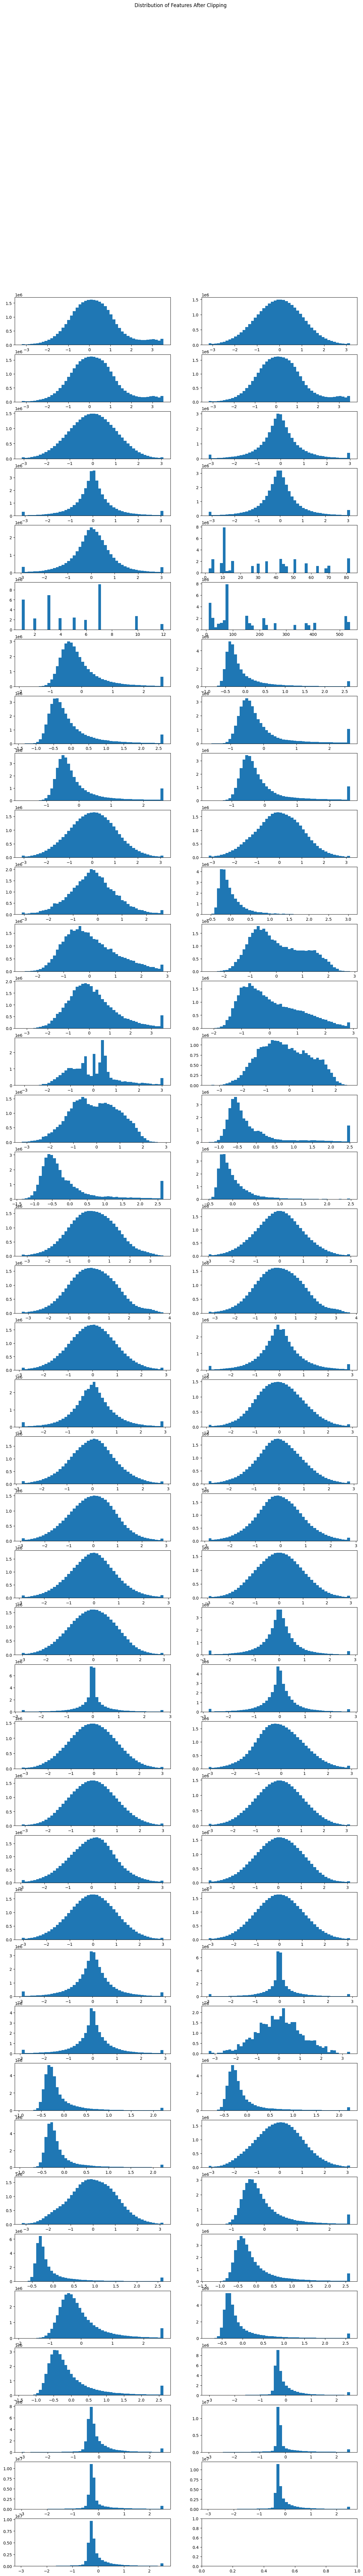

In [12]:
fig, axis = pyplot.subplots(40, 2, figsize=(15, 100))
fig.suptitle("Distribution of Features After Clipping")
for i, name in enumerate(features):
    axis[i // 2][i % 2].hist(df[name], bins=50)
fig.show()

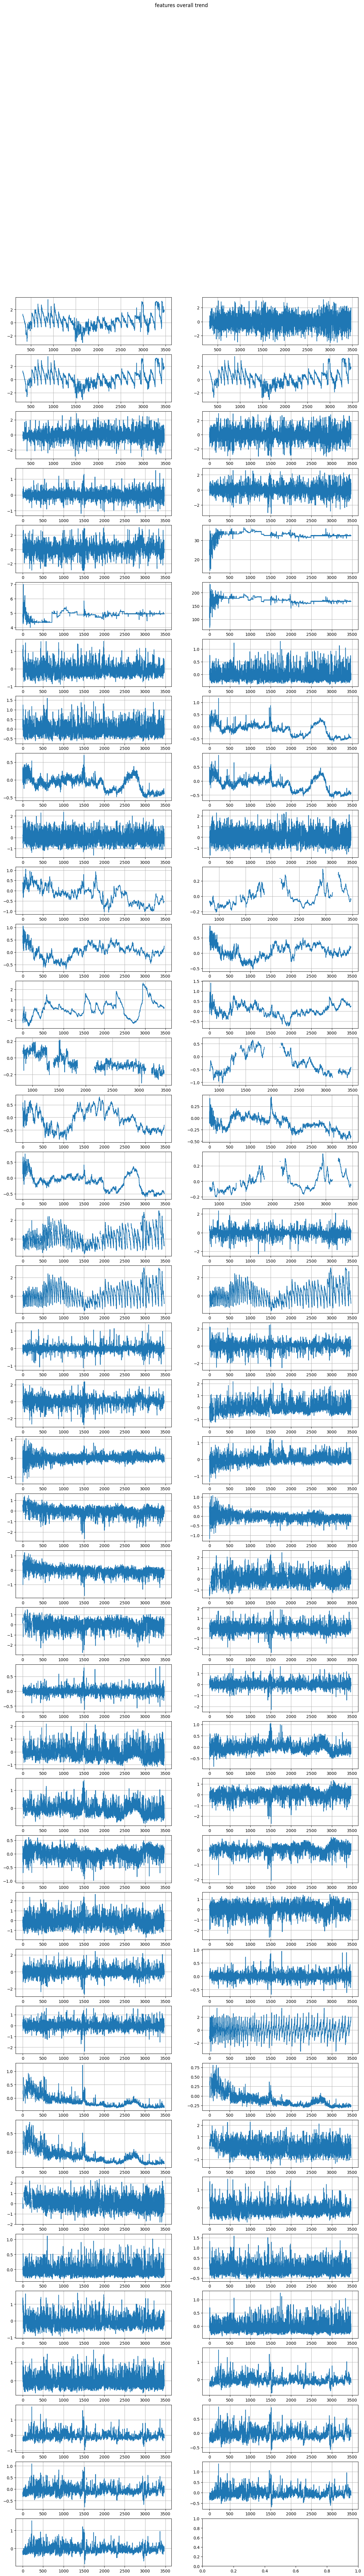

In [13]:
fig, axis = pyplot.subplots(40, 2, figsize=(15, 100))
fig.suptitle('features overall trend')
for i, name in enumerate(features):
    axis[i // 2][i % 2].plot(df[name].rolling_mean(1000)[::10000])
    axis[i // 2][i % 2].grid()
fig.show()

## Responder Data

In [14]:
responders = [i for i in df.columns if i.startswith('responder')]

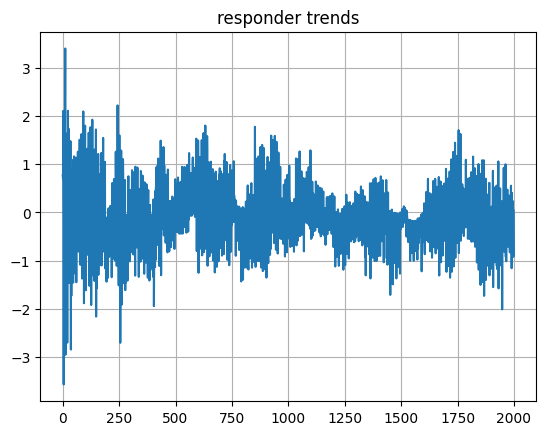

In [15]:
pyplot.figure()
pyplot.title('responder trends')
pyplot.plot(df['responder_6'][:2000])
pyplot.grid()
pyplot.show()

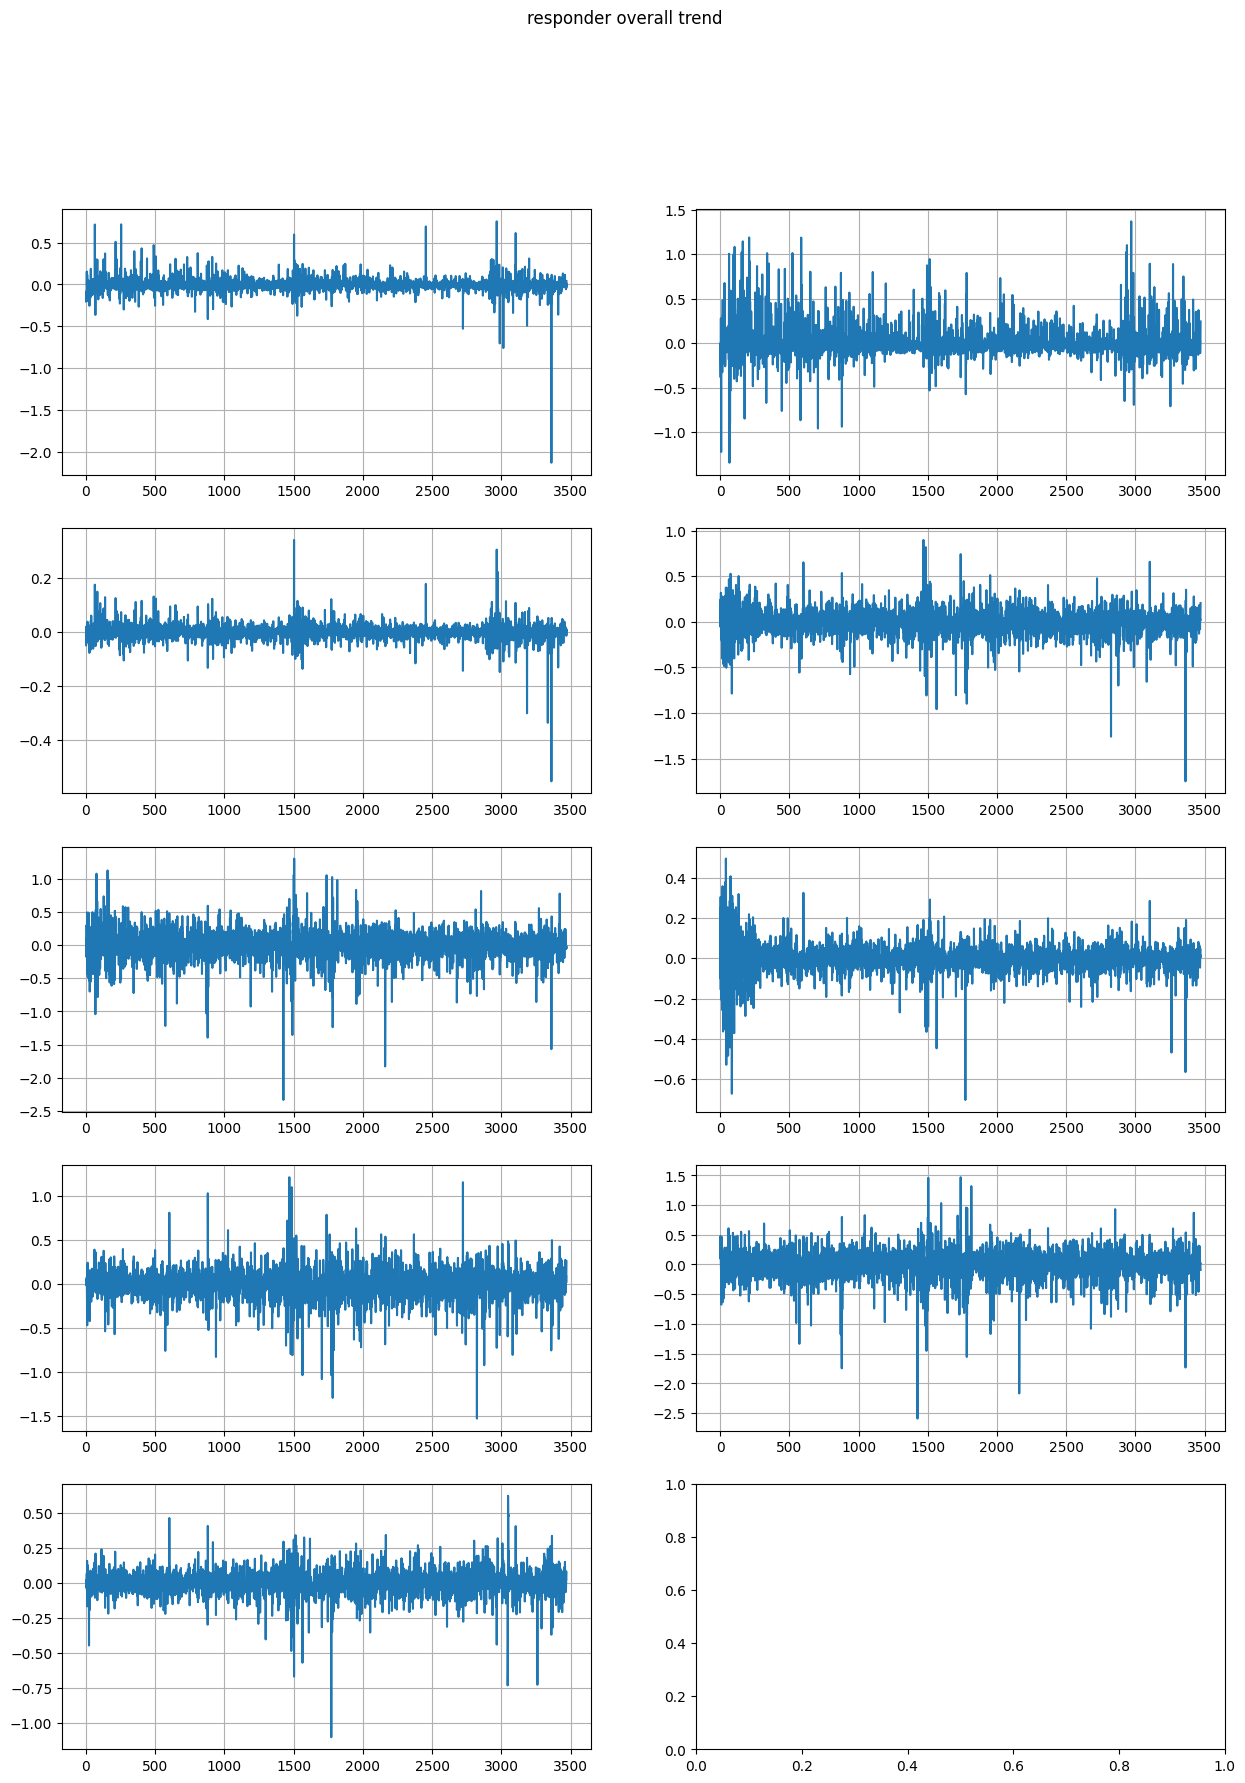

In [16]:
fig, axis = pyplot.subplots(5, 2, figsize=(15, 20))
fig.suptitle('responder overall trend')
for i, name in enumerate(responders):
    axis[i // 2][i % 2].plot(df[name].rolling_mean(1000)[::10000])
    axis[i // 2][i % 2].grid()
fig.show()

## Symbols

In [17]:
df.head()

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,…,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0,1,3.889038,null,null,null,null,null,0.851033,0.242971,0.2634,-0.891687,11,7,76,-0.883028,0.003067,-0.744703,null,-0.169586,null,-1.335938,-1.707803,0.91013,null,1.636431,1.522133,-1.551398,-0.229627,null,null,1.378301,-0.283712,0.123196,null,null,…,0.204797,null,null,-0.808103,null,-2.037683,0.727661,null,-0.989118,-0.345213,-1.36224,null,null,null,null,null,-1.251104,-0.110252,-0.491157,-1.02269,0.152241,-0.659864,null,null,-0.261412,-0.211486,-0.335556,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
0,0,7,1.370613,null,null,null,null,null,0.676961,0.151984,0.192465,-0.521729,11,7,76,-0.865307,-0.225629,-0.582163,null,0.317467,null,-1.250016,-1.682929,1.412757,null,0.520378,0.744132,-0.788658,0.641776,null,null,0.2272,0.580907,1.128879,null,null,…,1.172836,null,null,-1.625862,null,-1.410017,1.063013,null,0.888355,0.467994,-1.36224,null,null,null,null,null,-1.065759,0.013322,-0.592855,-1.052685,-0.393726,-0.741603,null,null,-0.281207,-0.182894,-0.245565,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.0,0.703665,0.216683,0.778639
0,0,9,2.285698,null,null,null,null,null,1.056285,0.187227,0.249901,-0.77305,11,7,76,-0.675719,-0.199404,-0.586798,null,-0.814909,null,-1.296782,-2.040234,0.639589,null,1.597359,0.657514,-1.350148,0.364215,null,null,-0.017751,-0.317361,-0.122379,null,null,…,0.535897,null,null,-0.72542,null,-2.29417,1.764551,null,-0.120789,-0.063458,-1.36224,null,null,null,null,null,-0.882604,-0.072482,-0.617934,-0.86323,-0.241892,-0.709919,null,null,0.377131,0.300724,-0.106842,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
0,0,10,0.690606,null,null,null,null,null,1.139366,0.273328,0.306549,-1.262223,42,5,150,-0.694008,2.63493,0.114809,null,-0.251882,null,-1.902009,-0.979447,0.241165,null,-0.392359,-0.224699,-2.129397,-0.855287,null,null,0.404142,-0.578156,0.105702,null,null,…,2.413415,null,null,1.313203,null,-0.810125,2.939022,null,2.90732,1.834661,-1.36224,null,null,null,null,null,-0.697595,1.074309,-0.206929,-0.530602,2.60811,0.571554,null,null,-0.226891,-0.251412,-0.215522,-0.296244,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
0,0,14,0.44057,null,null,null,null,null,0.9552,0.262404,0.344457,-0.613813,44,3,16,-0.947351,-0.030018,-0.502379,null,0.646086,null,-1.844685,-1.58656,-0.182024,null,-0.969949,-0.673813,-1.282132,-1.399894,null,null,0.043815,-0.320225,-0.031713,null,null,…,1.253902,null,null,0.476195,null,-0.771732,2.843421,null,1.379815,0.411827,-1.36224,null,null,null,null,null,-0.948601,-0.136814,-0.447704,-1.141761,0.099631,-0.661928,null,null,2.530213,2.528035,2.526386,2.538336,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.0,-3.57282,-1.089123,-5.0


In [18]:
df.group_by('symbol_id').len().sort('len')

symbol_id,len
i8,u32
18,252648
32,281688
6,286528
4,381392
31,393976
…,…
9,1223317
19,1224285
16,1227562


## Completeness

In [19]:
{name: (df[name].is_null().sum(), df.shape[0] - df[name].is_null().sum()) for name in df.columns}

{'date_id': (0, 34712738),
 'time_id': (0, 34712738),
 'symbol_id': (0, 34712738),
 'weight': (0, 34712738),
 'feature_00': (3182052, 31530686),
 'feature_01': (3182052, 31530686),
 'feature_02': (3182052, 31530686),
 'feature_03': (3182052, 31530686),
 'feature_04': (3182052, 31530686),
 'feature_05': (0, 34712738),
 'feature_06': (0, 34712738),
 'feature_07': (0, 34712738),
 'feature_08': (95999, 34616739),
 'feature_09': (0, 34712738),
 'feature_10': (0, 34712738),
 'feature_11': (0, 34712738),
 'feature_12': (0, 34712738),
 'feature_13': (0, 34712738),
 'feature_14': (0, 34712738),
 'feature_15': (901499, 33811239),
 'feature_16': (261, 34712477),
 'feature_17': (150538, 34562200),
 'feature_18': (226, 34712512),
 'feature_19': (226, 34712512),
 'feature_20': (0, 34712738),
 'feature_21': (8356609, 26356129),
 'feature_22': (0, 34712738),
 'feature_23': (0, 34712738),
 'feature_24': (0, 34712738),
 'feature_25': (0, 34712738),
 'feature_26': (8356609, 26356129),
 'feature_27': (835